In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
import pymeshlab as ml

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Open3D exploration

In [2]:
print("Load a ply point cloud, print it, and render it")
pcd = o3d.io.read_point_cloud("data/point_clouds/free_view_point/point_cloud_000000.ply")
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Load a ply point cloud, print it, and render it
PointCloud with 498664 points.
[[ 5070. -8005.   390.]
 [ 5100. -8005.   390.]
 [ 5075. -8015.   395.]
 ...
 [15005.  3520.  1720.]
 [14980.  3520.  1725.]
 [14995.  3520.  1725.]]


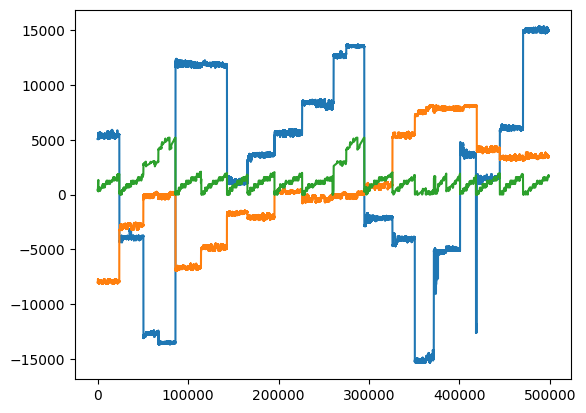

In [3]:
pcd_np = np.asarray(pcd.points)
plt.plot(pcd_np)

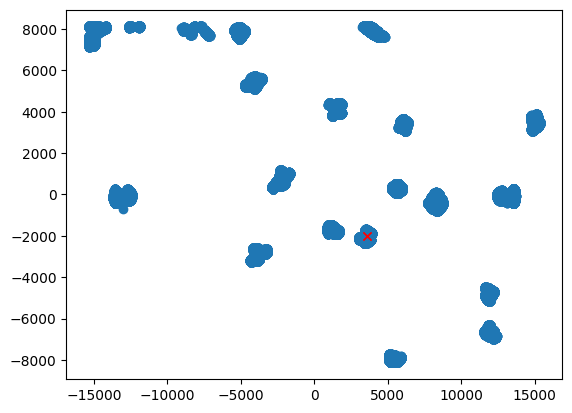

In [4]:
plt.scatter(pcd_np[:,0],pcd_np[:,1])
plt.plot(np.array([3600, 3601]), np.array([-2000, -2000]), color='red', marker='x')

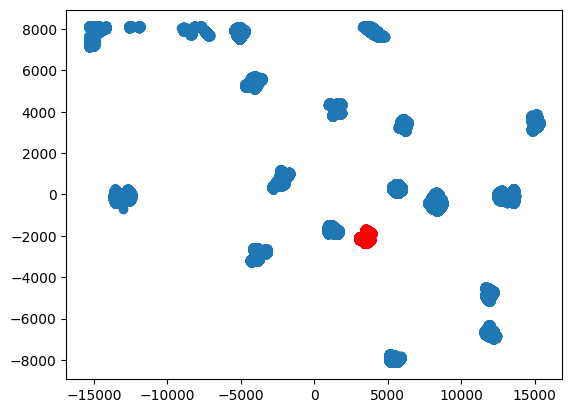

In [5]:
#Label pcd ids according to distances between the center and the pc
def label_pcd(pcd_np, center, rad=400): 
    d = np.sum((pcd_np - center)**2, axis=1)**0.5
    return d < rad

ids = label_pcd(pcd_np[:,:2], np.array([3600, -2000]), rad=800)
plt.scatter(pcd_np[:,0],pcd_np[:,1])
plt.scatter(pcd_np[ids][:,0], pcd_np[ids][:,1], color='red')

In [6]:
pcd_player = pcd.select_by_index(np.where(ids)[0])
pcd_player.points
# Visualize the point cloud (optional)
o3d.visualization.draw_geometries([pcd_player])

In [8]:
def standardize(vertices):
    return (vertices - vertices.mean(axis=0))/(max(vertices.std(axis = 0)) * 3)

In [9]:
pcd_player.points = o3d.utility.Vector3dVector(standardize(np.asarray(pcd_player.points)))
o3d.visualization.draw_geometries([pcd_player])

In [10]:
max(np.std(np.asarray(pcd_player.points), axis = 0))

0.33333333333333953

In [11]:
print("Compute the normal of the downsampled point cloud")
pcd_player.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=15, max_nn=30))
o3d.visualization.draw_geometries([pcd_player],point_show_normal=True)

Compute the normal of the downsampled point cloud


In [12]:
import time
t1 = time.time()
pcd_player.orient_normals_consistent_tangent_plane(k=10)
t2 = time.time()
print( f"normal orientation {t2-t1}" )

normal orientation 1.0064406394958496


In [13]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd_player, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh])

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 29888 / 29888
[Open3D DEBUG] #   Got kernel density: 0.0249999 (s), 412.684 (MB) / 412.684 (MB) / 507 (MB)
[Open3D DEBUG] #     Got normal field: 0.0470002 (s), 422.762 (MB) / 422.762 (MB) / 507 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.619395e-05 / 7.828849e-01
[Open3D DEBUG] #       Finalized tree: 0.0479999 (s), 436.543 (MB) / 436.543 (MB) / 507 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0610001 (s), 432.359 (MB) / 436.543 (MB) / 507 (MB)
[Open3D DEBUG] #Set point constraints: 0.0139999 (s), 424.109 (MB) / 436.543 (MB) / 507 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 458942 / 337208 / 187297
[Open3D DEBUG] Memory Usage: 424.109 MB
[Open3D DEBUG] # Linear system solved: 0.25 (s), 435.164 (MB) / 436.543 (MB) / 507 (MB)
[Open3D DEBUG] Got average: 0.00399995 (s), 430.145 (MB) / 436.543 (MB) / 507 (MB)
[Open3D DEBUG] Iso-Value: 5.069789e-01 = 1.515259e+04 / 2.988800e+04
[Open3D DEBU

# Generate .raw file containing vertices, triangles and colors

In [14]:
import os
import PIL
import time

import cupy as cp
import numpy as np
import open3d as o3d
from cupy_knn import LBVHIndex
# Load the original point cloud
original_points = cp.asarray(pcd_player.points, dtype=cp.float32)
original_colors = cp.asarray(pcd_player.colors, dtype=cp.float32)
print(pcd_player)

# Load the mesh from blender
vertices = cp.asarray(mesh.vertices, dtype=cp.float32)

ModuleNotFoundError: No module named 'cupy_knn'

In [ ]:
import os
import PIL
import time

import cupy as cp
import numpy as np
import open3d as o3d
from cupy_knn import LBVHIndex

def KNN_lookup_gpu(
    original_points: cp.ndarray, xyz_coords: cp.ndarray, nearest_neighbors: int
) -> tuple[cp.ndarray, cp.ndarray]:
    lbvh = LBVHIndex()
    lbvh.build(original_points)
    lbvh.prepare_knn_default(nearest_neighbors)
    idx, distances, _ = lbvh.query_knn(xyz_coords, nearest_neighbors)
    return distances, idx

def gen_raw_file_color(
    o3d.geometry.PointCloud,
    o3d.geometry.TriangleMesh,
    nearest_neighbors: int = 3,
    buffer_pct: float = 25.0,
    verbose = True
) -> tuple[o3d.geometry.TriangleMesh, cp.ndarray, list[int]]:
):
    # Load the original point cloud
    pcd = input_pcl
    original_points = cp.asarray(pcd.points, dtype=cp.float32)
    original_colors = cp.asarray(pcd.colors, dtype=cp.float32)
    if verbose:
        print(pcd)

    # Load the mesh from blender
    mesh = input_mesh
    vertices = cp.asarray(mesh.vertices, dtype=cp.float32)
    if verbose:
        print(mesh)

    start_time = time.perf_counter()

    # The meshes that come out of blender are kind of "puffy", so first move mesh vertices toward their nearest
    # point cloud neighbor; this shrinks the mesh to better fit the point cloud
    start_move_vertices = time.perf_counter()
    _, idx = KNN_lookup_gpu(original_points, vertices, 1)
    vertices = original_points[idx.flatten()]
    # add moved vertices back to mesh
    mesh.vertices = o3d.utility.Vector3dVector(vertices.get())
    if verbose:
        print(
            f"Moved mesh vertices to nearest point cloud neighbors, time: {time.perf_counter() - start_move_vertices:.4f} seconds"
        )

    # delete duplicated vertices, update triangles
    start_remove_duplicated_vertices = time.perf_counter()
    old_n_vertices = len(vertices)
    old_n_triangles = len(mesh.triangles)
    mesh.remove_duplicated_vertices()
    mesh.remove_degenerate_triangles()
    mesh.remove_unreferenced_vertices()
    vertices = cp.asarray(mesh.vertices, dtype=cp.int16)  # use int16 to force lossless encoding in Draco
    triangles = cp.asarray(mesh.triangles, dtype=cp.int32)
    if verbose:
        print(
            f"Removed {old_n_vertices - len(vertices)} duplicated vertices, {old_n_triangles - len(triangles)} degenerate triangles, "
            + f"time: {time.perf_counter() - start_remove_duplicated_vertices:.4f} seconds"
        )

    
    # sort vertices within triangles to avoid reordering by Draco
    start_sort_vertices = time.perf_counter()
    triangles = sort_triangle_vertices(triangles, vertices)
    # remove any faces that are permuted versions of other faces
    triangles, removed_indices = remove_permuted_faces(triangles)
    if verbose:
        print(
            f"Removed {len(removed_indices)} permuted faces, new total: {len(triangles)}, "
            + f"time: {time.perf_counter() - start_sort_vertices:.4f} seconds"
        )

    # create a texture_size x texture_size array split into texture_divisions x texture_divisions squares;
    # each square will contain the triangles that make up that portion of the total triangle area, and they will be
    # numbered within each square from largest to smallest, row by row.
    # Each pixel will contain the triangle number for that pixel in the texture (will be -1 if that pixel is not in a triangle)
    start_sort_triangles = time.perf_counter()
    n_triangles = len(triangles)
    max_per_bin = calculate_max_triangles_per_bin(texture_size, texture_divisions)
    split_indices, split_areas = split_triangles_into_equal_area_bins(
        triangles,
        vertices,
        n_bins=texture_divisions**2,
        max_per_bin=max_per_bin,
        return_sizes=True,
        remove_small=True,
        area_threshold_percent=0.01,
    )
    sorted_indices = cp.hstack(split_indices)
    triangles = triangles[sorted_indices]
    n_triangles_list = [len(triangles) for triangles in split_indices]
    if verbose:
        print(
            f"Sorted triangles by area, removed {n_triangles - sum(n_triangles_list)} small triangles, "
            + f"new total: {sum(n_triangles_list)}, time: {time.perf_counter() - start_sort_triangles:.4f} seconds"
        )
    n_triangles = sum(n_triangles_list)

    # preallocate arrays for overall triangle numbers and valid pixel mask
    start_triangle_numbers = time.perf_counter()
    triangle_numbers, valid_px_mask, triangle_sizes_list, grid_sizes_list = generate_triangle_numbers_grid(
        n_triangles_list, texture_size, texture_divisions, verbose=verbose
    )
    if verbose:
        print(
            f"Got triangle numbers, shape: {triangle_numbers.shape}, dtype: {triangle_numbers.dtype}, time: {time.perf_counter() - start_triangle_numbers:.4f} seconds"
        )

    # for each pixel, determine the UV coordinates of the vertices of the triangle it is in
    # output is shape (texture_size, texture_size, 3, 2) and will contain NaNs for pixels not in a triangle
    start_uv_coords = time.perf_counter()
    triangle_uv_coords = generate_triangle_uv_vertex_coords_grid(
        n_triangles_list, triangle_sizes_list, grid_sizes_list, texture_size, texture_divisions
    )
    # add a buffer to the UV coordinates to avoid edge bleeding
    triangle_uv_coords = buffer_uv_coords_barycenter(triangle_uv_coords, buffer_pct=buffer_pct)
    uv_coords = cp.full((texture_size, texture_size, 3, 2), cp.nan, dtype=cp.float32)
    uv_coords[valid_px_mask] = triangle_uv_coords[triangle_numbers[valid_px_mask]]
    if verbose:
        print(
            f"Got UV coords, shape: {uv_coords.shape}, dtype: {uv_coords.dtype}, time: {time.perf_counter() - start_uv_coords:.4f} seconds"
        )

    # determine weights as barycentric coordinates of each pixel in its triangle
    # output is shape (texture_size, texture_size, 3) and will contain NaNs for pixels not in a triangle
    start_xyz = time.perf_counter()
    ij_matrix = cp.indices((texture_size, texture_size)).transpose(1, 2, 0)  # shape (texture_size, texture_size, 2)
    weights = cp.linalg.solve(
        cp.concatenate([uv_coords, cp.ones_like(uv_coords[..., :1])], axis=-1).transpose(0, 1, 3, 2),
        cp.concatenate([ij_matrix, cp.ones_like(ij_matrix[..., :1])], axis=-1),
    ).astype(cp.float32)

    # determine the xyz coordinates corresponding to each pixel in the texture using the weights from above
    # output is shape (texture_size, texture_size, 3) and will contain NaNs for pixels not in a triangle
    xyz_coords = cp.einsum("ijkl,ijk->ijl", vertices[triangles][triangle_numbers].astype(cp.float32), weights)
    if verbose:
        print(
            f"Got XYZ coords, shape: {xyz_coords.shape}, dtype: {xyz_coords.dtype}, time: {time.perf_counter() - start_xyz:.4f} seconds"
        )

    # for each xyz coord, find the nearest k neighbors in the original point cloud and average their colors
    start_knn = time.perf_counter()
    distances, idx = KNN_lookup_gpu(
        original_points, xyz_coords[valid_px_mask].reshape(-1, 3), nearest_neighbors
    )  # returned distances are squared
    # calculate the weighted average of the colors of the nearest neighbors
    knn_weights = 1 / (distances + 1e-8)  # in case of divide by zero
    knn_weights /= cp.sum(knn_weights, axis=1, keepdims=True)
    colors = (cp.sum(original_colors[idx] * knn_weights[..., cp.newaxis], axis=1) * 255).astype(cp.uint8)
    if verbose:
        print(
            f"Got colors, shape: {colors.shape}, dtype: {colors.dtype} time: {time.perf_counter() - start_knn:.4f} seconds"
        )

    # create texture from colors, filling in NaNs with black
    start_texture = time.perf_counter()
    texture = cp.zeros((texture_size, texture_size, 3), dtype=cp.uint8)
    texture[valid_px_mask] = colors
    # texture[triangle_numbers % 2 == 1] = [255, 0, 0] # red for upper right triangles
    if lut is not None:
        texture_lut = np.array(apply_lut_to_texture(texture, lut))
        texture = cp.array(texture_lut, dtype=cp.uint8)

    if attach_texture_to_mesh or (save_texture and output_texture_path is not None):
        texture_cpu = o3d.geometry.Image(texture.get())
    if attach_texture_to_mesh:
        mesh.textures = [texture_cpu]

    # flip the texture vertically for correct output
    texture = cp.flip(texture, axis=0)

    # create texture coords for the mesh and save output to obj file
    if generate_texture_coords:
        texture_coords = triangle_uv_coords / texture_size
        # change from row, column to x, y
        texture_coords = texture_coords.reshape(-1, 2)[:, ::-1]
        # save both to the mesh
        texture_coords = texture_coords.astype(cp.float64).get()  # float64 is faster for some reason
        mesh.triangle_uvs = o3d.utility.Vector2dVector(texture_coords)
        if verbose:
            print(
                f"Got texture coords, shape: {texture_coords.shape}, time: {time.perf_counter() - start_texture:.4f} seconds"
            )

    # attach triangles regardless of whether texture coords are generated
    mesh.triangles = o3d.utility.Vector3iVector(triangles.get())

In [59]:
print(np.asarray(mesh.vertex_colors),np.asarray(mesh.vertex_colors).shape)
print(np.asarray(mesh.vertices),np.asarray(mesh.vertices).shape)
print(np.asarray(mesh.triangles),np.asarray(mesh.triangles).shape)

[[0.56078628 0.44314035 0.27058604]
 [0.7162584  0.57030562 0.33137726]
 [0.76452192 0.60005883 0.33752668]
 ...
 [0.09608651 0.17658848 0.11910591]
 [0.21433751 0.19383629 0.18569017]
 [0.10281251 0.16691646 0.14531043]] (46963, 3)
[[-1.06251657e-01  7.72356987e-04 -6.65209770e-01]
 [-1.75706744e-02  8.81668329e-02 -6.65209770e-01]
 [-1.75706744e-02 -1.28208399e-02 -6.65209770e-01]
 ...
 [ 5.44825792e-02  4.11689281e-04  6.22425914e-01]
 [ 6.00251555e-02  4.11689281e-04  6.21214986e-01]
 [ 5.44825792e-02  5.95426559e-03  6.21844053e-01]] (46963, 3)
[[   17   114     0]
 [  123   114    17]
 [   17    25   123]
 ...
 [46315 46309 46144]
 [46309 46392 46144]
 [46315 46145 46053]] (93926, 3)


## Use pymeshlab instead

In [42]:
vertices = np.asarray(pcd_player.points)
colors = np.asarray(pcd_player.colors)

# Load the point cloud into MeshLab
ms = ml.MeshSet()
ms.add_mesh(
    ml.Mesh(
        vertex_matrix=vertices, v_color_matrix=np.hstack([colors, np.ones((len(colors), 1))])
    )
)

# ms.apply_filter('generate_simplified_point_cloud')
#Generate Normals and Reconstruct Mesh
ms.compute_normal_for_point_clouds(k=50) #default is 10
#ms.generate_marching_cubes_rimls()
ms.generate_surface_reconstruction_screened_poisson()
ms.apply_filter("compute_texcoord_by_function_per_vertex")
ms.apply_filter("compute_texcoord_transfer_vertex_to_wedge")
ms.apply_filter("compute_texcoord_parametrization_triangle_trivial_per_wedge", textdim=4096, border = 2, method='Space-optimizing')
ms.apply_filter("compute_texmap_from_color", textname=f"Processing.png", textw=4096, texth=4096)
ms.save_current_mesh(f"Processing.obj", save_face_color=True, save_wedge_texcoord=True, save_wedge_normal=False)

In [39]:
m = ms.current_mesh()
v_matrix = m.vertex_matrix()
f_matrix = m.face_matrix()
print(v_matrix.shape)
vertices.shape
colors.shape
f_matrix.shape

(45971, 3)


(91950, 3)

In [40]:
ms.save_current_mesh("player_mesh.obj")

In [44]:
m.face_color()

AttributeError: 'pymeshlab.pmeshlab.Mesh' object has no attribute 'face_color'

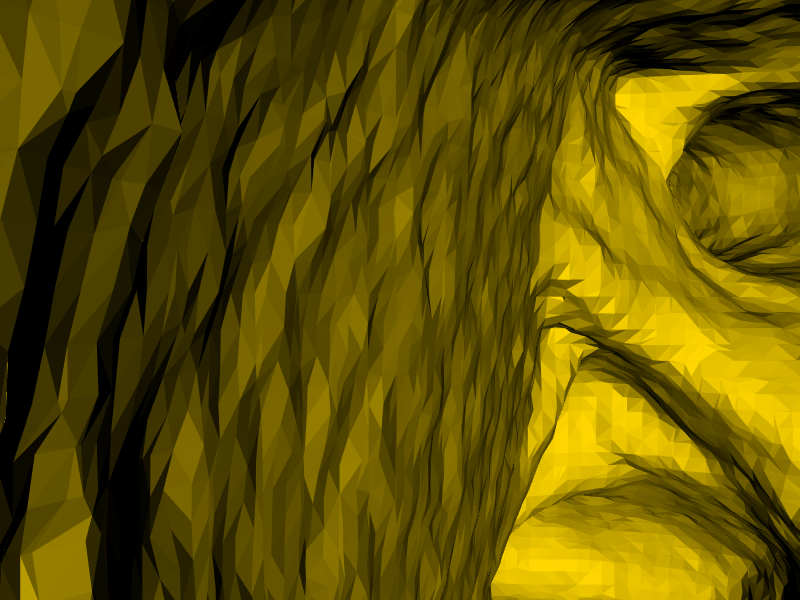

In [50]:
import vedo
mesh_vedo = vedo.Mesh([mesh.vertices, mesh.triangles])

# Show the mesh using Vedo
vedo.show(mesh_vedo)

In [52]:
mesh.colors

AttributeError: 'open3d.cpu.pybind.geometry.TriangleMesh' object has no attribute 'colors'

In [48]:
print(np.asarray(pcd_player.colors))
print(np.asarray(pcd_player.points))
print(np.asarray(pcd_player.normals))

[[0.2745098  0.22745098 0.15686275]
 [0.32156863 0.25098039 0.16470588]
 [0.29803922 0.23529412 0.14901961]
 ...
 [0.09019608 0.15686275 0.1372549 ]
 [0.19215686 0.16078431 0.16470588]
 [0.09411765 0.11372549 0.0627451 ]]
[[ 3105. -2160.   110.]
 [ 3110. -2155.   110.]
 [ 3115. -2150.   110.]
 ...
 [ 3640. -2050.  2050.]
 [ 3645. -2045.  2050.]
 [ 3590. -1920.  1925.]]
[[-0.59583171  0.38645366 -0.70401573]
 [-0.26808183  0.58025468 -0.76904918]
 [-0.31949092  0.82700311 -0.46259205]
 ...
 [-0.37904978  0.12278927  0.91719358]
 [ 0.04349287  0.26346194  0.96368884]
 [ 0.02631015  0.97628054  0.21490482]]


In [49]:
np.asarray(pcd_player.points).shape

(29888, 3)

(array([ 816.,  586.,  277.,  284., 4427., 6355., 6602., 7691., 2508.,
         342.]),
 array([-0.33404964, -0.27962196, -0.22519427, -0.17076659, -0.11633891,
        -0.06191123, -0.00748355,  0.04694414,  0.10137182,  0.1557995 ,
         0.21022718]),
 <BarContainer object of 10 artists>)

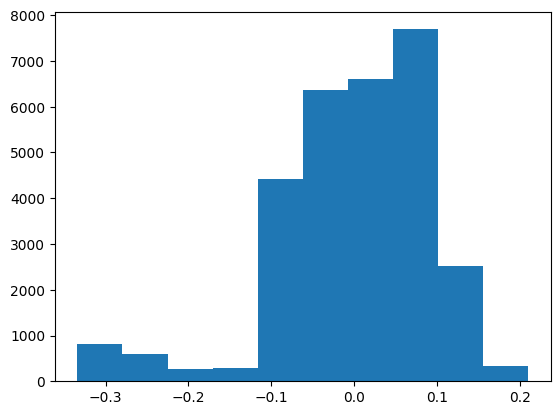

In [48]:
def standardize(vertices):
    return (vertices - vertices.mean(axis=0))/(max(vertices.std(axis = 0)) * 3)

plt.hist(standardize(np.asarray(pcd_player.points))[:,0])



In [18]:
max(np.std(np.asarray(pcd_player.points), axis = 0))

529.7549383408931

## Save ply data as a raw type file that contains pcd, normals, colors

In [56]:
import struct

def save_ply_to_raw(filename, vertices, normals, colors):
    with open(filename, 'wb') as output:
        # Write the number of vertices
        nv = len(vertices)
        output.write(struct.pack('I', nv))

        # Write the vertices
        for vertex in vertices:
            output.write(struct.pack('fff', *vertex))

        # Write the number of faces
        nf = len(normals)
        output.write(struct.pack('I', nf))

        # Write the normals
        for norm in normals:
            output.write(struct.pack('fff', *norm))

        # Write the num of colors
        nc = len(colors)
        output.write(struct.pack('I', nc))

        # Write the colors
        for color in colors:
            output.write(struct.pack('fff', *color))   

        

# Example usage:

save_ply_to_raw('player_pcd.bin', 
                standardize(np.asarray(pcd_player.points)), 
                np.asarray(pcd_player.normals),
                np.asarray(pcd_player.colors))

In [33]:
print("Downsample the point cloud with a voxel of 10")
downpcd = pcd.voxel_down_sample(voxel_size=10)
o3d.visualization.draw_geometries([downpcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Downsample the point cloud with a voxel of 10


In [36]:
print("Compute the normal of the downsampled point cloud")
downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True)

Compute the normal of the downsampled point cloud


In [21]:
file_path = "data/point_clouds/dfaust/pointcloud.npz"

with np.load(file_path) as data:
    print( data.files)
    points = data["points"].astype(np.float64)
    normals = data["normals"].astype(np.float64)
    vertices = data['points']

['loc', 'scale', 'points', 'normals']


In [22]:
len(points)

100000

In [23]:
from vedo import Points
from vedo import show

In [24]:
# Create an Open3D point cloud object
pcd = o3d.geometry.PointCloud()

# Set the points of the point cloud to the loaded vertices
pcd.points = o3d.utility.Vector3dVector(vertices)

# Visualize the point cloud (optional)
o3d.visualization.draw_geometries([pcd])

In [25]:
# Create a MeshNormalsVisualizer object
#vis = o3d.visualization.MeshNormalsVisualizer()

# Attach the normals to the point cloud
pcd.normals = o3d.utility.Vector3dVector(normals)
pcd.paint_uniform_color([0.7, 0.7, 0.7])  # Set point cloud color

PointCloud with 100000 points.

In [26]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 100000 / 78563
[Open3D DEBUG] #   Got kernel density: 0.043 (s), 472.812 (MB) / 472.812 (MB) / 500 (MB)
[Open3D DEBUG] #     Got normal field: 0.176 (s), 509.949 (MB) / 509.949 (MB) / 509 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 7.803329e-06 / 7.803329e-01
[Open3D DEBUG] #       Finalized tree: 0.19 (s), 547.43 (MB) / 547.43 (MB) / 557 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.164 (s), 529.66 (MB) / 547.43 (MB) / 557 (MB)
[Open3D DEBUG] #Set point constraints: 0.066 (s), 518.195 (MB) / 547.43 (MB) / 557 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 1032319 / 1179688 / 105
[Open3D DEBUG] Memory Usage: 518.195 MB
[Open3D DEBUG] # Linear system solved: 0.399 (s), 559.152 (MB) / 559.152 (MB) / 559 (MB)
[Open3D DEBUG] Got average: 0.00699997 (s), 517.195 (MB) / 559.152 (MB) / 559 (MB)
[Open3D DEBUG] Iso-Value: 5.040493e-01 = 5.040493e+04 / 1.000000e+05
[Open3D DEBUG] #          Total Solve

In [27]:
o3d.visualization.draw_geometries([mesh], point_show_normal=True)

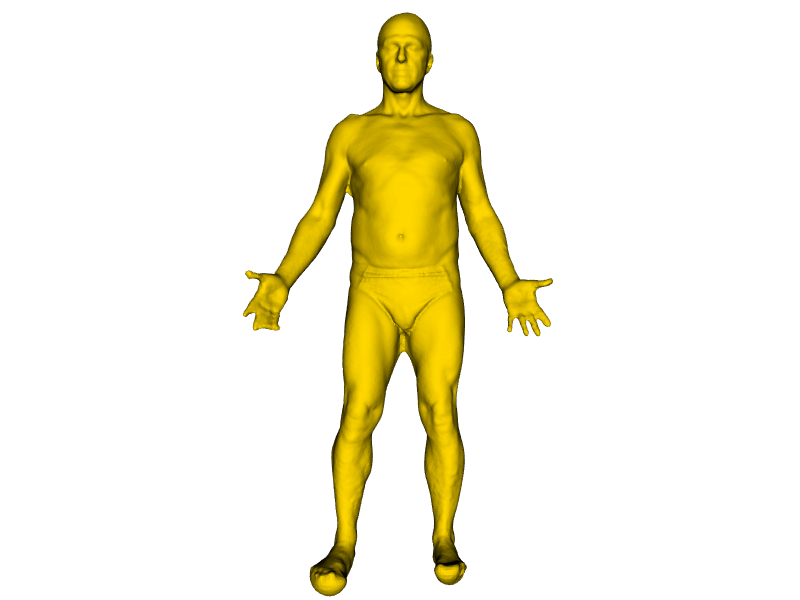

In [28]:
import vedo
mesh_vedo = vedo.Mesh([mesh.vertices, mesh.triangles])

# Show the mesh using Vedo
show(mesh_vedo)

float64


(array([ 4260.,  6147., 15838., 36712., 29915., 29585., 41610., 15401.,
         7054.,  3053.]),
 array([-2.32159972e-01, -1.85726392e-01, -1.39292812e-01, -9.28592324e-02,
        -4.64256525e-02,  7.92741776e-06,  4.64415073e-02,  9.28750873e-02,
         1.39308667e-01,  1.85742247e-01,  2.32175827e-01]),
 <BarContainer object of 10 artists>)

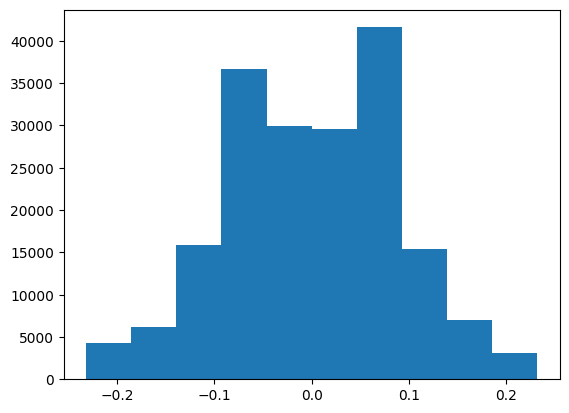

In [34]:
print(np.asarray(mesh.vertices).dtype)
plt.hist(np.asarray(mesh.vertices)[:,0])

In [90]:
np.asarray(pcd.points)

array([[ 0.08825684, -0.21008301, -0.02774048],
       [-0.16772461,  0.06616211, -0.01363373],
       [-0.02229309,  0.02064514,  0.03536987],
       ...,
       [-0.19421387, -0.02536011,  0.05773926],
       [-0.19873047, -0.02397156,  0.05734253],
       [-0.19372559, -0.02589417,  0.05871582]])

In [66]:
import struct

def save_raw(filename, vertices, faces, colors = None):
    with open(filename, 'wb') as output:
        # Write the number of vertices
        nv = len(vertices)
        output.write(struct.pack('I', nv))

        # Write the vertices
        for vertex in vertices:
            output.write(struct.pack('fff', *vertex))

        # Write the number of faces
        nf = len(faces)
        output.write(struct.pack('I', nf))

        # Write the faces
        for face in faces:
            output.write(struct.pack('III', *face))

        #code below can be commented out to just save points and faces
        # Write the num of colors
        nc = len(colors)
        output.write(struct.pack('I', nc))

        # Write the colors
        for color in colors:
            output.write(struct.pack('fff', *color))  

In [67]:
save_raw('player_mesh_color.bin', np.asarray(mesh.vertices), np.asarray(mesh.triangles), np.asarray(mesh.vertex_colors))

In [61]:
np.asarray(mesh.vertices)

array([[-1.06251657e-01,  7.72356987e-04, -6.65209770e-01],
       [-1.75706744e-02,  8.81668329e-02, -6.65209770e-01],
       [-1.75706744e-02, -1.28208399e-02, -6.65209770e-01],
       ...,
       [ 5.44825792e-02,  4.11689281e-04,  6.22425914e-01],
       [ 6.00251555e-02,  4.11689281e-04,  6.21214986e-01],
       [ 5.44825792e-02,  5.95426559e-03,  6.21844053e-01]])

In [49]:
standardize(np.asarray(mesh.vertices))

array([[-1.76343147e-02,  8.83068058e-02, -6.71229442e-01],
       [ 7.09301240e-02,  2.18341533e-02, -6.71229442e-01],
       [-1.20990373e-02,  8.89301382e-02, -6.71229442e-01],
       ...,
       [ 5.43242918e-02,  4.19548767e-04,  6.14986003e-01],
       [ 5.98595692e-02,  4.19548767e-04,  6.13654039e-01],
       [ 5.43242918e-02,  5.95482618e-03,  6.14393815e-01]])

In [64]:
np.asarray(mesh.vertex_colors)

array([[0.56078628, 0.44314035, 0.27058604],
       [0.7162584 , 0.57030562, 0.33137726],
       [0.76452192, 0.60005883, 0.33752668],
       ...,
       [0.09608651, 0.17658848, 0.11910591],
       [0.21433751, 0.19383629, 0.18569017],
       [0.10281251, 0.16691646, 0.14531043]])

In [71]:
mesh.textures

[]